# Figures for *Practical Bayesian Tomography* #

[Christopher Granade](http://www.cgranade.com/), Joshua Combes and D. G. Cory.
$
\newcommand{\id}{\unicode{x1D7D9}}
\newcommand{\sket}[1]{|#1\rangle\!\rangle}
\newcommand{\sbraket}[1]{\langle\!\langle#1\rangle\!\rangle}
\newcommand{\sbra}[1]{\langle\!\langle#1|}
$

## Preamble

In [1]:
from __future__ import division
%matplotlib inline

In [2]:
import numpy as np
import qutip as qt
import qinfer as qi

qt.settings.colorblind_safe = True
qt.settings.debug = False

In [3]:
from functools import partial

In [4]:
from IPython.display import display

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib import rcParams
rcParams['legend.fontsize'] = 'x-large'
rcParams['axes.labelsize'] = 'large'

Finally, we define a function to make nice snippets for LaTeX inclusion. In the future, this should by an IPython magic.

In [6]:
import os
FIGURE_PATH = os.path.join('../figures')

In [7]:
def paper_figure(name, code, caption="", width=0.6, incl_listing=False, figopts=None):
    fname = '{}.pdf'.format(name)
    fpath = os.path.join(FIGURE_PATH, fname)
    
    snippet = r"""
        \begin{{figure}}
            \begin{{center}}
                \includegraphics[width={width}\columnwidth]{{\figurefolder/{fname}}}{listing}
            \end{{center}}
            \caption{{
                \label{{fig:{name}}}
                {caption}
            }}
        \end{{figure}}
    """.format(width=width, fname=fname, name=name, caption=caption.strip(), listing="" if not incl_listing else r"""
                \begin{{lstlisting}}{{style=python}}
{code}
                \end{{lstlisting}}
""".format(code=code.strip()))
    print snippet
    
    figure = plt.figure(**(figopts if figopts is not None else dict()))
    exec(code)
    plt.savefig(fpath, format='pdf')
    
    return figure

In [8]:
I, X, Y, Z = qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()

In [9]:
import tempfile as tf

## GAD Prior ##

In [10]:
prior_mean = (I + (2/3) * Z + (1/3) * X) / 2
display(prior_mean)

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.83333333  0.16666667]
 [ 0.16666667  0.16666667]]


        \begin{figure}
            \begin{center}
                \includegraphics[width=0.6\columnwidth]{\figurefolder/gadfli-rebit.pdf}
            \end{center}
            \caption{
                \label{fig:gadfli-rebit}
                Fiducial and insightful priors for a single rebit, with the mean
    state $\rho_\mu = \frac12(\id + \frac23 \sigma_z + \frac13 \sigma_x)$.
            }
        \end{figure}
    


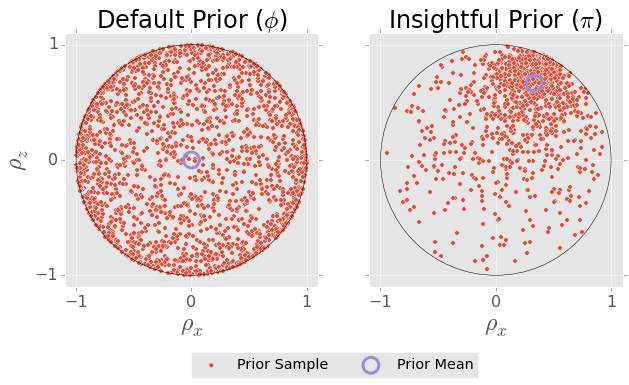

In [11]:
paper_figure('gadfli-rebit', r"""
I, X, Y, Z = qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()
prior_mean = (I + (2/3) * Z + (1/3) * X) / 2

basis = qi.tomography.pauli_basis(1)
fiducial_prior = qi.tomography.GinibreReditDistribution(basis)
prior = qi.tomography.GADFLIDistribution(fiducial_prior, prior_mean)

plt.subplot(121)
qi.tomography.plotting_tools.plot_rebit_prior(fiducial_prior, legend=False, rebit_axes=[1, 3], force_mean=I / 2)
plt.xlabel(r'$\rho_x$', size=24)
plt.ylabel(r'$\rho_z$', size=24)
plt.xticks([-1, 0, 1], size=16)
plt.yticks([-1, 0, 1], size=16)
plt.title(r'Default Prior ($\phi$)', size=24)

plt.subplot(122)
qi.tomography.plotting_tools.plot_rebit_prior(prior, legend=False, rebit_axes=[1, 3])
plt.xlabel(r'$\rho_x$', size=24)
plt.ylabel('', size=24)
plt.xticks([-1, 0, 1], size=16)
plt.yticks([-1, 0, 1], size=16)
plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.title(r'Insightful Prior ($\pi$)', size=24)
# http://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots-with-matplotlib
plt.legend([
        'Prior Sample', 'Prior Mean'
    ],
    loc='lower center', bbox_to_anchor=(0, 0.2, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=2, scatterpoints=1
)

plt.subplots_adjust()

""", incl_listing=False, figopts={'figsize': (10, 10)}, caption=r'''
    Fiducial and insightful priors for a single rebit, with the mean
    state $\rho_\mu = \frac12(\id + \frac23 \sigma_z + \frac13 \sigma_x)$.
''');

## Rebit Robustness Check

Saving to /tmp/tmpwNEoEU...


/home/cgranade/anaconda/lib/python2.7/site-packages/qinfer/utils.py:109: ApproximationWarning: Numerical error in covariance estimation causing positive semidefinite violation.
  warnings.warn('Numerical error in covariance estimation causing positive semidefinite violation.', ApproximationWarning)


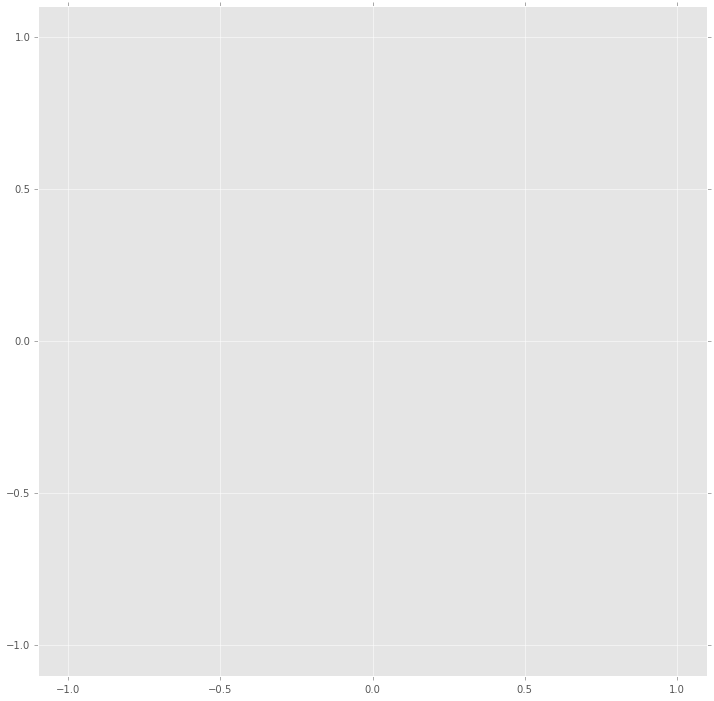

In [12]:
basis = qi.tomography.pauli_basis(1)
model = qi.BinomialModel(qi.tomography.TomographyModel(basis))
true_state = basis.state_to_modelparams(
    I / 2 + (9 / 10) * X / 2
)[np.newaxis, :]
fiducial_prior = qi.tomography.GinibreReditDistribution(basis)
prior = qi.tomography.GADFLIDistribution(fiducial_prior,
    I / 2 - (9 / 10) * X / 2
)

updater = qi.smc.SMCUpdater(model, 4000, prior)
heuristic = qi.tomography.RandomPauliHeuristic(updater, other_fields={'n_meas': 10})

# Plot the history of the covariance region as the bad prior
# is corrected into the good posterior.
tempdir = tf.mkdtemp()
print "Saving to {}...".format(tempdir)
robustness_fig, ax_rebit = plt.subplots(1, 1, figsize=(1920 * 12 / 1080, 12))
plt.sca(ax_rebit)

for idx_exp in xrange(30):
    experiment = heuristic()
    datum = model.simulate_experiment(true_state, experiment)
    updater.update(datum, experiment)
    
    qi.tomography.plot_rebit_posterior(updater, prior=None, true_state=true_state, rebit_axes=[1, 3], true_size=600)
    plt.xticks([-1, 0, 1], size=14)
    plt.yticks([-1, 0, 1], size=14)

    plt.savefig(os.path.join(tempdir, '{:05}.png'.format(idx_exp)), dpi=1080 * 100 / 1200)
    
    ax_rebit.clear()


        \begin{figure}
            \begin{center}
                \includegraphics[width=0.6\columnwidth]{\figurefolder/robust-rebit.pdf}
            \end{center}
            \caption{
                \label{fig:robust-rebit}
                Fiducial and insightful priors for a single rebit, with the mean
   state $\rho_\mu = \frac12(\id + \frac23 \sigma_z + \frac13 \sigma_x)$.
            }
        \end{figure}
    


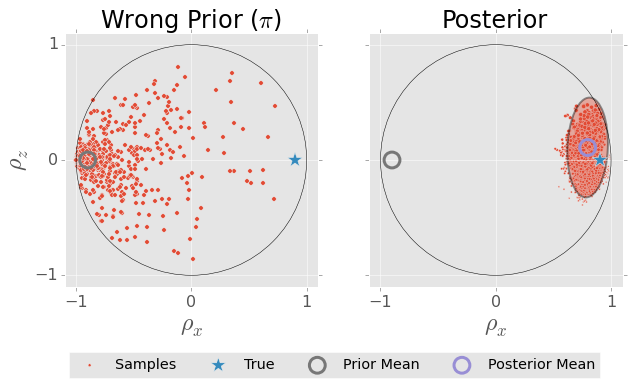

In [13]:
paper_figure('robust-rebit', r"""
    
qi.tomography.plotting_tools.plot_rebit_posterior(
    updater, prior, true_state,
    rebit_axes=[1, 3]
)

plt.subplot(121)
qi.tomography.plotting_tools.plot_rebit_prior(prior, true_state=true_state, rebit_axes=[1, 3], legend=False, mean_color_index=3)
plt.xlabel(r'$\rho_x$', size=24)
plt.ylabel(r'$\rho_z$', size=24);
plt.xticks([-1, 0, 1], size=16)
plt.yticks([-1, 0, 1], size=16)
plt.title(r'Wrong Prior ($\pi$)', size=24)

plt.subplot(122)
qi.tomography.plotting_tools.plot_rebit_posterior(updater, prior, true_state=true_state, rebit_axes=[1, 3], legend=False)
plt.xlabel(r'$\rho_x$', size=24)
plt.ylabel('')
plt.xticks([-1, 0, 1], size=16)
plt.yticks([-1, 0, 1], size=16)
plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.title(r'Posterior', size=24)
# http://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots-with-matplotlib
plt.legend([
        'Samples', 'True', 'Prior Mean', 'Posterior Mean'
    ],
    loc='lower center', bbox_to_anchor=(0, 0.2, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=4, scatterpoints=1
)

plt.subplots_adjust()

""", incl_listing=False, figopts={'figsize': (10, 10)}, caption=r'''
   Fiducial and insightful priors for a single rebit, with the mean
   state $\rho_\mu = \frac12(\id + \frac23 \sigma_z + \frac13 \sigma_x)$.
''');

## Qutrit Risks ##

In [14]:
qutrit_basis = qi.tomography.gell_mann_basis(3)
default_prior = qi.tomography.distributions.GinibreDistribution(qutrit_basis)

In [15]:
insightful_mean = qt.Qobj([
    [0.9, 0, 0],
    [0, 0.05, 0],
    [0, 0, 0.05]
]).unit()
insightful_prior = qi.tomography.distributions.GADFLIDistribution(default_prior, insightful_mean)

biased_insightful_mean = qt.Qobj([
    [0.87, 0, 0],
    [0, 0.065, 0],
    [0, 0, 0.065]
]).unit()
biased_insightful_prior = qi.tomography.distributions.GADFLIDistribution(default_prior, biased_insightful_mean)

nearortho_insightful_mean = qt.Qobj([
    [0.065, 0, 0],
    [0, 0.065, 0],
    [0, 0, 0.87]
]).unit()
nearortho_insightful_prior = qi.tomography.distributions.GADFLIDistribution(default_prior, nearortho_insightful_mean)

qutrit_model = qi.BinomialModel(qi.tomography.TomographyModel(qutrit_basis))
qutrit_heuristic = partial(qi.tomography.RandomStabilizerStateHeuristic, other_fields={'n_meas': 20})

We quickly define a function to [count](http://stackoverflow.com/questions/2324820/count-warnings-in-python-2-4) the number of ``n_ess`` warnings.

In [16]:
import warnings
def run_and_count_warnings(prior, perf_testing_args):
    with warnings.catch_warnings(record=True) as warning_record:
        perfdata = qi.perf_test_multiple(
            prior=prior,
            **perf_testing_args
        )
        
    print "\t{} n_ess warnings.".format(len(['n_ess' in str(warning) for warning in warning_record]))
    return perfdata

In [17]:
perf_testing_args = dict(
    n_trials=1200, model=qutrit_model, n_particles=6000,
    n_exp=200, heuristic_class=qutrit_heuristic,
    allow_failures=False,#True,
    #apply=dview.apply_async,
    progressbar=qt.ui.TextProgressBar,
    true_prior=insightful_prior
)

print "Default..."
default_qutrit_perfdata = run_and_count_warnings(
    default_prior,
    perf_testing_args
)

print "Insightful..."
insightful_qutrit_perfdata = run_and_count_warnings(
    insightful_prior,
    perf_testing_args
)

print "Biased..."
biased_qutrit_perfdata = run_and_count_warnings(
    biased_insightful_prior,
    perf_testing_args
)

print "Nearly Orthogonal..."
nearothro_qutrit_perfdata = run_and_count_warnings(
    nearortho_insightful_prior, perf_testing_args
)

Default...
10.0%. Run time: 1594.12s. Est. time left: 00:03:59:07
20.0%. Run time: 3093.75s. Est. time left: 00:03:26:14
30.0%. Run time: 4596.97s. Est. time left: 00:02:58:46
40.0%. Run time: 6104.80s. Est. time left: 00:02:32:37
50.0%. Run time: 7625.62s. Est. time left: 00:02:07:05
60.0%. Run time: 9118.90s. Est. time left: 00:01:41:19
70.0%. Run time: 10646.33s. Est. time left: 00:01:16:02
80.0%. Run time: 12165.82s. Est. time left: 00:00:50:41
90.0%. Run time: 13656.70s. Est. time left: 00:00:25:17
Total run time: 15147.97s
	28 n_ess warnings.
Insightful...
10.0%. Run time: 1317.95s. Est. time left: 00:03:17:41
20.0%. Run time: 2651.04s. Est. time left: 00:02:56:44
30.0%. Run time: 3938.26s. Est. time left: 00:02:33:09
40.0%. Run time: 5249.86s. Est. time left: 00:02:11:14
50.0%. Run time: 6536.89s. Est. time left: 00:01:48:56
60.0%. Run time: 7850.07s. Est. time left: 00:01:27:13
70.0%. Run time: 9175.23s. Est. time left: 00:01:05:32
80.0%. Run time: 10408.20s. Est. time left: 00


        \begin{figure}
            \begin{center}
                \includegraphics[width=0.6\columnwidth]{\figurefolder/qutrit-risk-v1.pdf}
            \end{center}
            \caption{
                \label{fig:qutrit-risk-v1}
                Risk of SMC-based tomography for a qutrit, using three different priors,
    with true states drawn from the generalized amplitude damping distribution
    for $\rho_\mu = \diag(0.9, 0.05, 0.05)$.
    The default prior is taken to be the full-rank qutrit Ginibre distribution,
    while the insightful prior is taken to be identical to the actual distribution
    over true states and the biased prior uses the mean $\rho_\mu = \diag(0.87, 0.065, 0.065)$.
    The nearly orthogonal prior is taken to be insightful with the mean
    $\rho_\mu = \diag(0.065, 0.065, 0.87)$.
    Risk is measured with respect to the quadratic loss function on
    vectorized density operators, $L(\hat{\rho}, \rho) = \|\sket{\hat{\rho}} - \sket{\rho}\|_2$.
    The risk is 

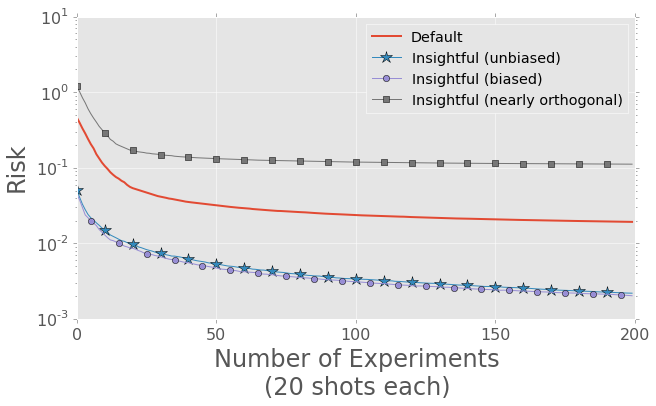

In [18]:
paper_figure("qutrit-risk-v1", r""" 
plt.semilogy(np.mean(default_qutrit_perfdata['loss'][:, :], axis=0), lw=2, label='Default')
plt.semilogy(np.mean(insightful_qutrit_perfdata['loss'][:, :], axis=0),
    '*-', markersize=12, markevery=10, label='Insightful (unbiased)',
)
plt.semilogy(np.mean(biased_qutrit_perfdata['loss'][:, :], axis=0),
    'o-', markersize=6, markevery=(5, 10), label='Insightful (biased)'
)
plt.semilogy(np.mean(nearothro_qutrit_perfdata['loss'][:, :], axis=0),
    's-', markersize=6, markevery=10, label='Insightful (nearly orthogonal)'
)
plt.legend(numpoints=1)
plt.xlabel('Number of Experiments\n(20 shots each)', size=24)
plt.ylabel('Risk', size=24)
plt.xticks(size=16)
plt.yticks(size=16)
plt.gcf().subplots_adjust(bottom=0.2)
""", incl_listing=False, figopts={'figsize': (10, 6)}, caption=r'''
    Risk of SMC-based tomography for a qutrit, using three different priors,
    with true states drawn from the generalized amplitude damping distribution
    for $\rho_\mu = \diag(0.9, 0.05, 0.05)$.
    The default prior is taken to be the full-rank qutrit Ginibre distribution,
    while the insightful prior is taken to be identical to the actual distribution
    over true states and the biased prior uses the mean $\rho_\mu = \diag(0.87, 0.065, 0.065)$.
    The nearly orthogonal prior is taken to be insightful with the mean
    $\rho_\mu = \diag(0.065, 0.065, 0.87)$.
    Risk is measured with respect to the quadratic loss function on
    vectorized density operators, $L(\hat{\rho}, \rho) = \|\sket{\hat{\rho}} - \sket{\rho}\|_2$.
    The risk is averaged over 1200 trials. Measurements are chosen to be rank-1 projectors
    onto randomly drawn single-qutrit stabilizer states. Each such stabilizer state is then measured
    20 times.
''');

### QPT Example ###

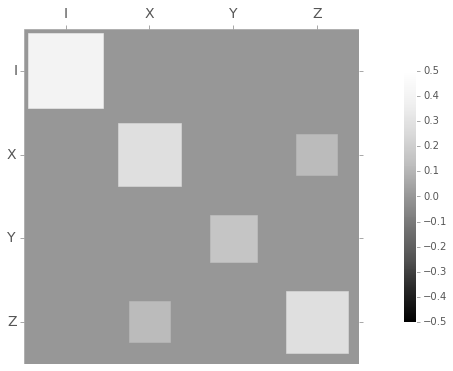

In [19]:
true_mean_channel = qt.to_choi(0.7 * qt.to_super(qt.qeye(2)) + 0.3 * qt.to_super(qt.hadamard_transform())).unit()
qt.visualization.hinton(true_mean_channel);

In [20]:
state_basis = qi.tomography.pauli_basis(1)
channel_fiducial_prior = qi.tomography.BCSZChoiDistribution(state_basis)
channel_basis = channel_fiducial_prior.basis

(<matplotlib.figure.Figure at 0x7f8a85818b50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8a81c060d0>)

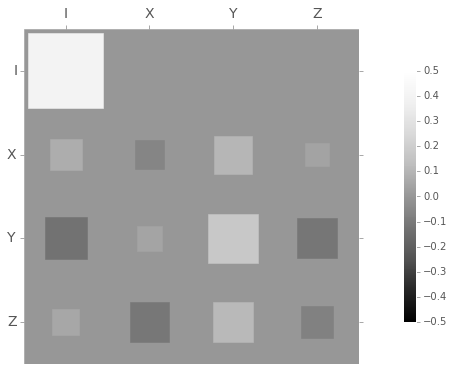

In [21]:
qt.visualization.hinton(channel_basis.modelparams_to_state(channel_fiducial_prior.sample())[0])

In [22]:
insightful_mean_channel = true_mean_channel * 0.9  + (0.1 / 4) * qt.to_choi(
    qt.to_super(I) * qt.to_super(X) + qt.to_super(Y) + qt.to_super(Z)
)

(<matplotlib.figure.Figure at 0x7f8a81274810>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8a811f6190>)

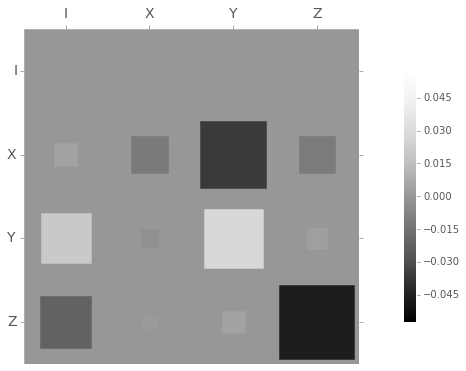

In [23]:
channel_prior = qi.tomography.GADFLIDistribution(
    channel_fiducial_prior, insightful_mean_channel
)
true_channel = channel_prior.basis.modelparams_to_state(channel_prior.sample()[0])
qt.visualization.hinton(channel_prior.basis.modelparams_to_state(channel_prior.sample())[0] - true_channel)

In [24]:
channel_model = qi.BinomialModel(qi.tomography.TomographyModel(channel_prior.basis))
channel_updater = qi.smc.SMCUpdater(channel_model, 6000, channel_prior)

In [25]:
channel_base_heurstic = qi.tomography.ProductHeuristic(
    channel_updater, state_basis,
    qi.tomography.RandomStabilizerStateHeuristic,
    qi.tomography.RandomStabilizerStateHeuristic,
    other_fields={
        'n_meas': 60
    }
)

In [26]:
channel_heuristic = qi.EnsembleHeuristic([
    (channel_base_heurstic, 0.2),
    (qi.tomography.BestOfKMetaheuristic(
        channel_updater,
        channel_base_heurstic, k=50,
        other_fields={
            'n_meas': 60
        }), 0.8
     )
])

In [27]:
true_channel_mps = channel_prior.basis.state_to_modelparams(true_channel)[None, :]

In [28]:
loss_hist = []

In [29]:
for idx_experiment in xrange(450):
    experiment = channel_heuristic()
    outcome = channel_model.simulate_experiment(true_channel_mps, experiment)
    channel_updater.update(outcome, experiment)
    est_channel = channel_prior.basis.modelparams_to_state(channel_updater.est_mean())
    loss_hist.append(np.linalg.norm(true_channel_mps - channel_updater.est_mean()))

(<matplotlib.figure.Figure at 0x7f8a81258ad0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8a812584d0>)

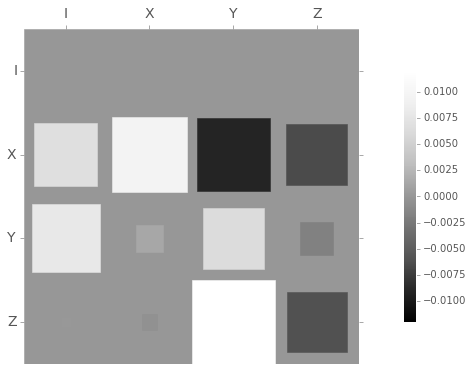

In [30]:
qt.visualization.hinton(est_channel - true_channel)


        \begin{figure}
            \begin{center}
                \includegraphics[width=0.6\columnwidth]{\figurefolder/qpt-loss.pdf}
            \end{center}
            \caption{
                \label{fig:qpt-loss}
                Example quadratic between estimated and true channels for SMC-based tomography
    for a qubit channel $\Lambda[\rho] = 0.7 \rho + 0.3 H\rho H$, where $H$ is
    a Hadamard. The prior for both the SMC
    estimator and the true channel is taken to be the insightful prior
    with a mean taken to be a 90\% mixture of the true channel and 10\% of
    a completely depolarizing channel. Each experiment is chosen by proposing 50
    different random pairs of Pauli preparations and measurements, then
    selecting the one which has the maximum expectation value
    $\sbraket{\Sigma} = \sbraket{P, M | \Sigma | P, M}$, where $\Sigma$ is
    the current covariance superoperator.
            }
        \end{figure}
    


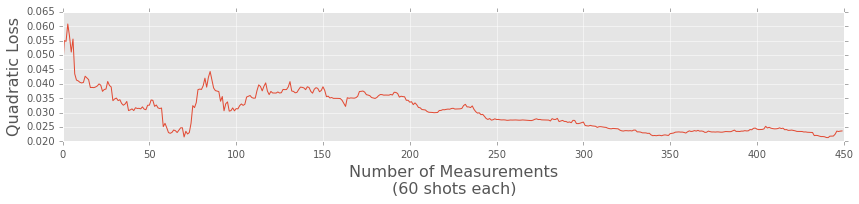

In [31]:
paper_figure("qpt-loss", r"""
plt.plot(loss_hist)
plt.xlabel('Number of Measurements\n(60 shots each)', size=16)
plt.ylabel('Quadratic Loss', size=16)
plt.gcf().subplots_adjust(bottom=0.3)
""", incl_listing=False, figopts={'figsize': (14, 3)}, caption=r'''
    Example quadratic between estimated and true channels for SMC-based tomography
    for a qubit channel $\Lambda[\rho] = 0.7 \rho + 0.3 H\rho H$, where $H$ is
    a Hadamard. The prior for both the SMC
    estimator and the true channel is taken to be the insightful prior
    with a mean taken to be a 90\% mixture of the true channel and 10\% of
    a completely depolarizing channel. Each experiment is chosen by proposing 50
    different random pairs of Pauli preparations and measurements, then
    selecting the one which has the maximum expectation value
    $\sbraket{\Sigma} = \sbraket{P, M | \Sigma | P, M}$, where $\Sigma$ is
    the current covariance superoperator.
''');


        \begin{figure}
            \begin{center}
                \includegraphics[width=0.6\columnwidth]{\figurefolder/qpt-cov.pdf}
            \end{center}
            \caption{
                \label{fig:qpt-cov}
                
            }
        \end{figure}
    


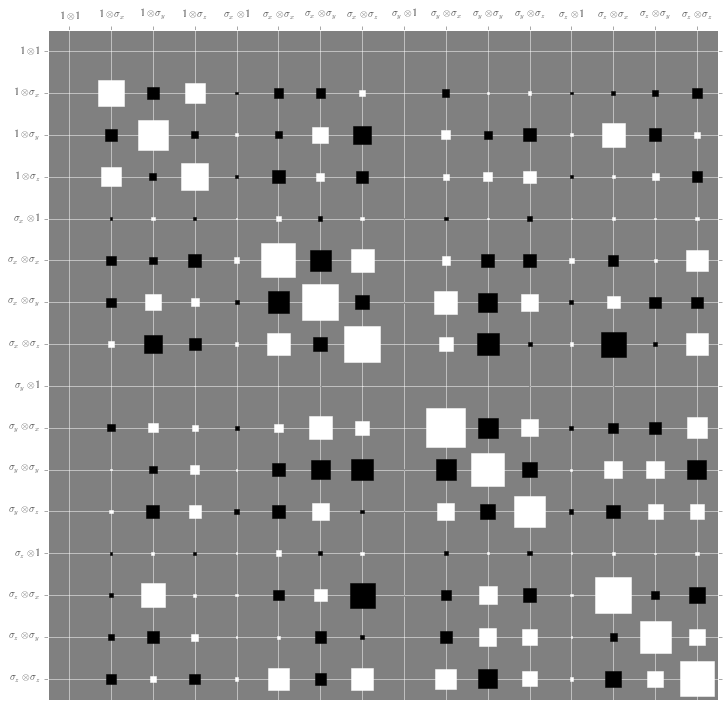

In [32]:
paper_figure("qpt-cov", r"""
channel_updater.plot_covariance(tick_labels=map(u'${}$'.format, channel_model.base_model.basis.labels))
""", incl_listing=False, figopts={'figsize': (12, 12)}, caption=r'''
''');


        \begin{figure}
            \begin{center}
                \includegraphics[width=0.6\columnwidth]{\figurefolder/qpt-cov-spectrum.pdf}
            \end{center}
            \caption{
                \label{fig:qpt-cov-spectrum}
                
            }
        \end{figure}
    


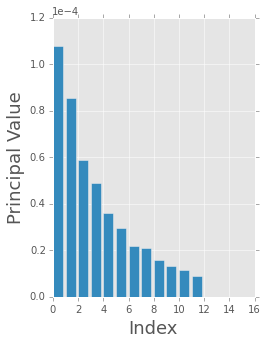

In [33]:
paper_figure("qpt-cov-spectrum", r"""
plt.bar(*(lambda xs: (np.arange(len(xs)), list(reversed(sorted(xs)))))(np.linalg.eigvals(channel_updater.est_covariance_mtx())))
plt.ylim(ymin=0);
plt.xlabel('Index', size=18)
plt.ylabel('Principal Value', size=18)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.gcf().subplots_adjust(left=0.2)
""", incl_listing=False, figopts={'figsize': (4, 5)}, caption=r'''
''');


        \begin{figure}
            \begin{center}
                \includegraphics[width=0.6\columnwidth]{\figurefolder/qpt-cov-principal.pdf}
            \end{center}
            \caption{
                \label{fig:qpt-cov-principal}
                
            }
        \end{figure}
    


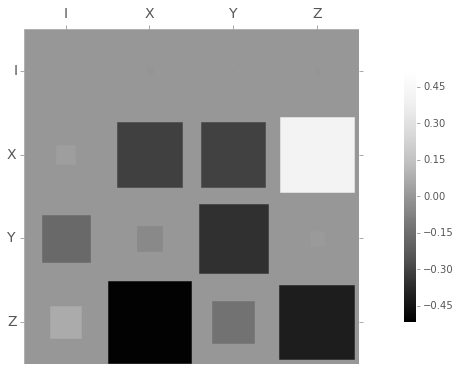

In [34]:
paper_figure("qpt-cov-principal", r"""
qt.visualization.hinton(channel_prior.basis.modelparams_to_state(np.linalg.eigh(channel_updater.est_covariance_mtx())[1][:, -1]))
""", incl_listing=False, figopts={'figsize': (6, 6)}, caption=r'''
''');


## Other ##

### Diffusive Coin ###

In [35]:
class DiffusiveCoinModel(qi.Model):
    @property
    def n_modelparams(self): return 2
    @property
    def modelparam_names(self): return ['p', r'\sigma']
    @property
    def expparams_dtype(self): return [('t', float)]
    @property
    def is_n_outcomes_constant(self): return True
    def are_models_valid(self, modelparams):
        return np.all([
            modelparams[:, 0] >= 0,
            modelparams[:, 0] <= 1,
            modelparams[:, 1] >= 0
        ], axis=0)
    def n_outcomes(self, expparams): return 2
    
    def likelihood(self, outcomes, modelparams, expparams):
        super(DiffusiveCoinModel, self).likelihood(outcomes, modelparams, expparams)
        return qi.Model.pr0_to_likelihood_array(outcomes, 1 - modelparams[:, 0, None])
    
    def update_timestep(self, modelparams, expparams):
        p, sigma = modelparams.T
        t = expparams['t']
        
        p_new = np.clip((np.random.randn(*p.shape) * sigma)[:, None] * np.sqrt(t) + p[:, None], 0, 1)
        mps_new = np.empty((p.shape[0], 2, t.shape[0]))
        mps_new[:, 0, :] = p_new
        mps_new[:, 1, :] = sigma[:, None]
        
        return mps_new


        \begin{figure}
            \begin{center}
                \includegraphics[width=0.6\columnwidth]{\figurefolder/diffusive-coin-two-tone.pdf}
            \end{center}
            \caption{
                \label{fig:diffusive-coin-two-tone}
                Diffusive tracking of a coin state (bias), with the true coin state evolving as
    a two-tone sinusoidal function.
            }
        \end{figure}
    


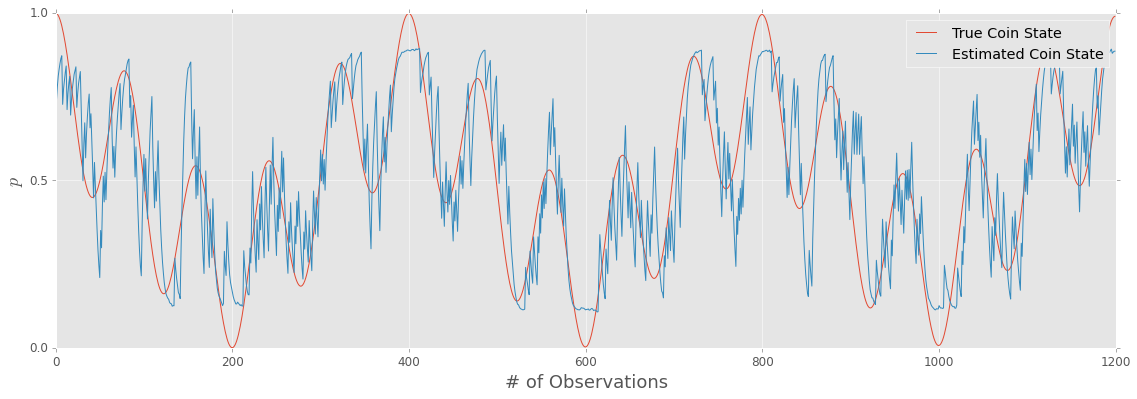

In [36]:
paper_figure("diffusive-coin-two-tone", """    
prior = qi.UniformDistribution([[0, 1], [0, 1]])
model = DiffusiveCoinModel()
true = prior.sample(1)
t = 0.03
expparams = np.array([(t,)], dtype=model.expparams_dtype)
updater = qi.smc.SMCUpdater(model, 2000, prior)

true_hist = []
est_hist = []
for idx_exp in xrange(1200):
    true = (np.array([[np.cos(idx_exp * np.pi / 40), 0]]) + 1) / 4 +  (np.array([[np.cos(idx_exp * np.pi / 197), 0]]) + 1) / 4
    outcome = model.simulate_experiment(true, expparams)
    updater.update(outcome, expparams)
    
    est_hist.append(updater.est_mean()[0])
    true_hist.append(true[:, 0])
    
plt.plot(range(1200), true_hist, label='True Coin State')
plt.plot(range(1200), est_hist, label='Estimated Coin State')
plt.xlabel(r'# of Observations', size=18)
plt.ylabel(r'$p$', size=18)
plt.yticks([0, 0.5, 1], size=12)
plt.xticks(size=12)
plt.legend()
""", incl_listing=False, figopts={'figsize': (19, 6)}, caption=r'''
    Diffusive tracking of a coin state (bias), with the true coin state evolving as
    a two-tone sinusoidal function.
''');

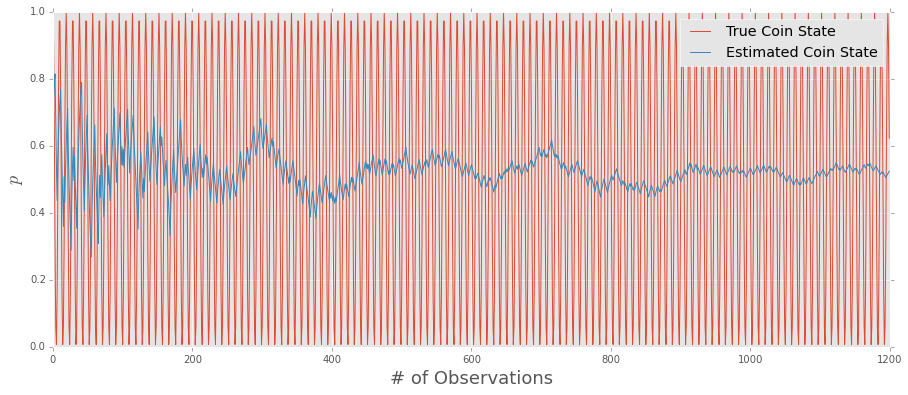

In [37]:
prior = qi.UniformDistribution([[0, 1], [0, 1]])
model = DiffusiveCoinModel()
true = prior.sample(1)
t = 0.03
expparams = np.array([(t,)], dtype=model.expparams_dtype)
updater = qi.smc.SMCUpdater(model, 2000, prior)

true_hist = []
est_hist = []
for idx_exp in xrange(1200):
    true = (np.array([[np.cos(idx_exp * np.pi / (9.5 / 2)), 0]]) + 1) / 2
    outcome = model.simulate_experiment(true, expparams)
    updater.update(outcome, expparams)
    
    est_hist.append(updater.est_mean()[0])
    true_hist.append(true[:, 0])
    
plt.figure(figsize=(15, 6))
plt.plot(range(1200), true_hist, label='True Coin State')
plt.plot(range(1200), est_hist, label='Estimated Coin State')
plt.xlabel(r'# of Observations', size=18)
plt.ylabel(r'$p$', size=18)
plt.legend()